In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


In [3]:
PATH = 'data/'
sz = 100
# architecture used
arch = resnet34
bs = 32

In [4]:
#list of directories in PATH
os.listdir(PATH)

['models', 'tmp', 'Training', 'Validation']

In [5]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms=tfms, trn_name="Training", val_name='Validation')

In [6]:
#Give the number of classes
data.c

64

In [7]:
data.classes[:4]

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3']

Number of pictures the traning set

In [8]:
data.trn_ds.n

31688

In [9]:
#Read in images and their labels given as sub-folder names
learn = ConvLearner.pretrained(arch, data, precompute = True)
lrf = learn.lr_find()

 76%|████████████████████████████████████████████████████▍                | 754/991 [00:09<00:03, 78.15it/s, loss=1.75]


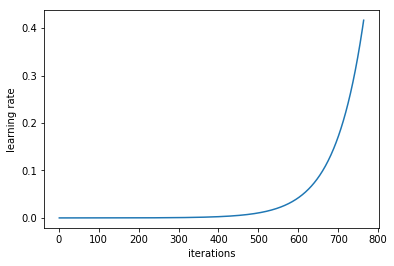

In [10]:
learn.sched.plot_lr()

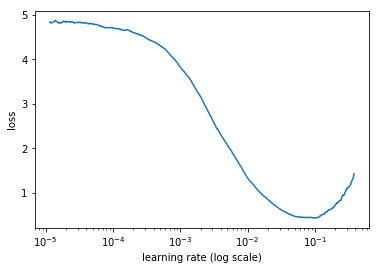

In [11]:
learn.sched.plot()

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.080587   0.101398   0.965656  



[0.10139782155579134, 0.9656563760908323]

In [13]:
learn.precompute=False

In [14]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.112141   0.081506   0.968378  
    1      0.078768   0.084059   0.96819                                                                               
    2      0.070576   0.072159   0.972882                                                                              



[0.07215853718215959, 0.9728816740170779]

In [15]:
learn.unfreeze()

In [16]:
lr=np.array([1e-4, 1e-3, 1e-2])

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.035819   0.041644   0.983016  
    1      0.021981   0.032031   0.98433                                                                               
    2      0.019443   0.028666   0.986394                                                                              
    3      0.028445   0.032216   0.986957                                                                              
    4      0.01433    0.025973   0.987238                                                                              
    5      0.034798   0.02744    0.987614                                                                              
    6      0.034463   0.028244   0.986206                                                                              



[0.02824384324756675, 0.986206249413531]

In [18]:
learn.save('model_resnet34')

In [19]:
learn.load('model_resnet34')

In [20]:
log_preds,y = learn.TTA()

probs = np.mean(np.exp(log_preds),0)

In [21]:
preds = np.argmax(np.mean(log_preds, 0), axis = 1)

In [22]:
preds = np.argmax(probs, axis = 1)

In [23]:
accuracy_np(probs, y)

0.9885521253636108

In [24]:
#Define a function which return n_ex distincts numbers (here means examples) from one mask
def rand_by_mask(mask,n_ex): return np.random.choice(np.where(mask)[0], n_ex, replace=False)

In [25]:
#This function use previous function and return 4 examples corresponding to correct classfication(correct or wrong)
def rand_by_correct(is_correct, n_ex): return rand_by_mask((preds == data.val_y)==is_correct, n_ex)

In [26]:
#define a plot function
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [28]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [29]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [f'{np.max(probs[x],0)}\nPred : {data.classes[np.argmax(probs[x],0)]}\nActual : {data.classes[y[x]]}' for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


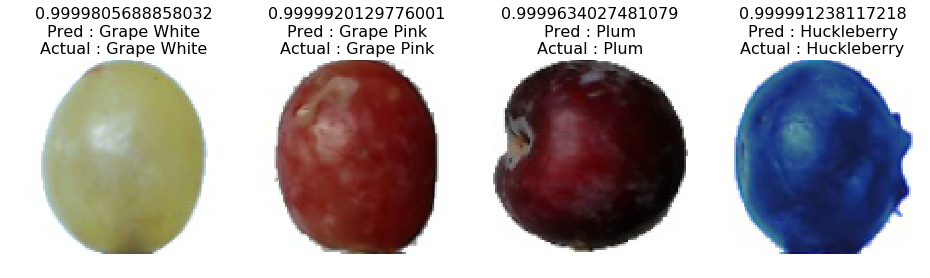

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,4),"Correctly classified")

Incorrectly classified


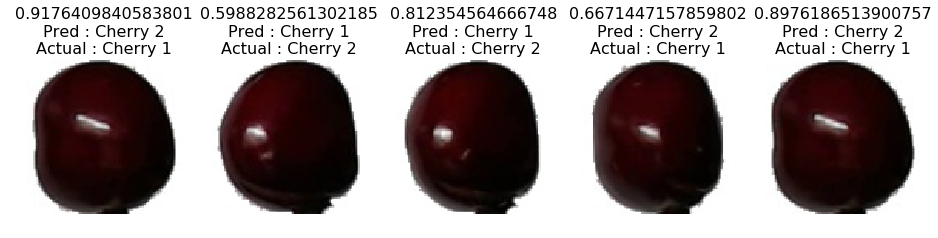

In [40]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False,5), "Incorrectly classified")

In [32]:
def most_by_mask(mask, mult,n_ex):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:n_ex]]

In [33]:
def most_by_correct(y, is_correct, n_ex):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult, n_ex)

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
confus=[]
for i in range(cm.shape[0]):
    tot=np.sum(cm,1)[i]
    for j in range(cm.shape[0]):
        if cm[i,j]!=0 and cm[i,j]!=tot and data.classes[i]!=data.classes[j]:
            confus.append([cm[i,j], tot, round(cm[i,j]/tot,2), data.classes[i],data.classes[j]])
confus_arr = np.array(confus)

In [35]:
confus_arr

array([['1', '164', '0.01', 'Apple Red 2', 'Apple Braeburn'],
       ['60', '164', '0.37', 'Cherry 1', 'Cherry 2'],
       ['55', '246', '0.22', 'Cherry 2', 'Cherry 1'],
       ['1', '164', '0.01', 'Pear', 'Apple Golden 2'],
       ['1', '164', '0.01', 'Pear', 'Apple Granny Smith'],
       ['3', '166', '0.02', 'Pepino', 'Grape White'],
       ['1', '166', '0.01', 'Pepino', 'Peach Flat']], dtype='<U32')

In [36]:
cm

array([[164,   0,   0, ...,   0,   0,   0],
       [  0, 164,   0, ...,   0,   0,   0],
       [  0,   0, 164, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 164,   0,   0],
       [  0,   0,   0, ...,   0, 166,   0],
       [  0,   0,   0, ...,   0,   0, 166]], dtype=int64)

[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0   0 164   0   0]
 [  0   0   0 161   0]
 [  0   0   0   0 164]]


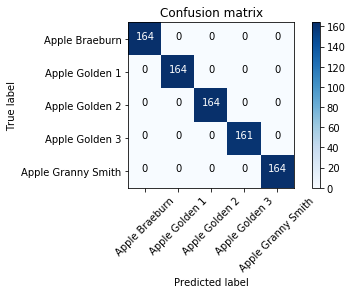

In [37]:
import numpy as np
#np.set_printoptions(threshold=np.nan)

plot_confusion_matrix(cm[0:5,0:5], data.classes[0:5])
